Train Set Shape: (1618172, 15), Labels: (1618172,)
Test Set Shape: (404543, 15), Labels: (404543,)
Training Isolation Forest model...


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   10.6s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:   42.6s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   10.4s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:   42.4s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.5s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:   10.3s



Train Accuracy: 0.6546
Test Accuracy: 0.6546

Classification Report (Test Set):
              precision    recall  f1-score   support

      Benign       0.66      0.99      0.79    266244
     Anomaly       0.32      0.01      0.02    138299

    accuracy                           0.65    404543
   macro avg       0.49      0.50      0.40    404543
weighted avg       0.54      0.65      0.53    404543



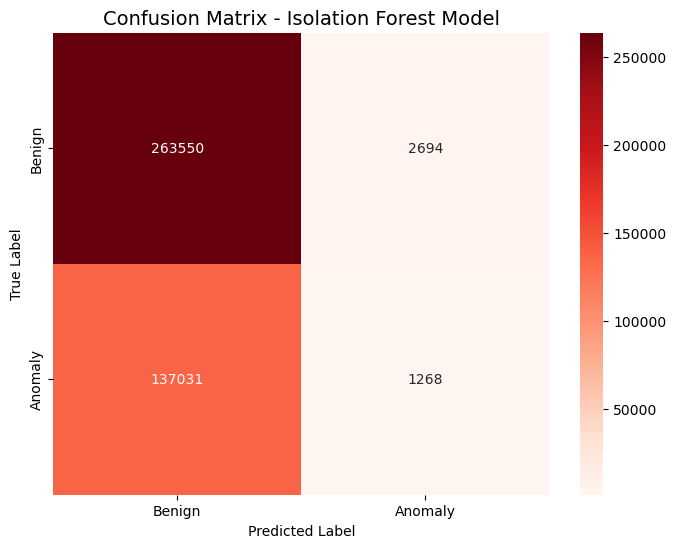

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.6s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:   10.7s


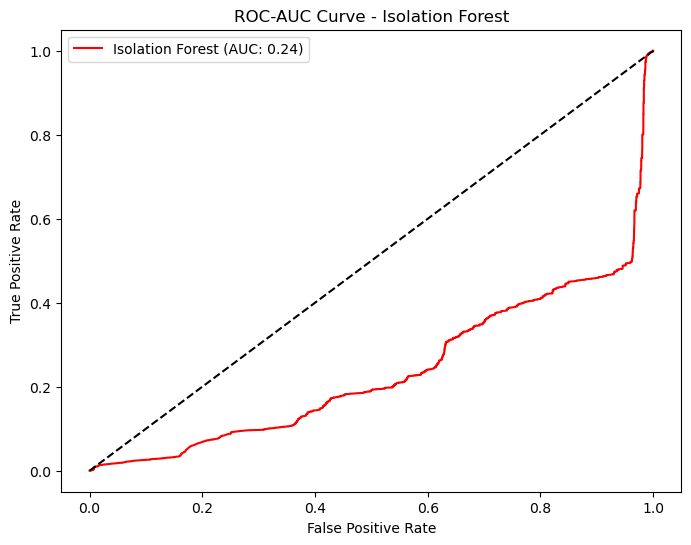


Final Evaluation Summary:
Train Accuracy: 0.6546
Test Accuracy: 0.6546
Confusion matrix and ROC curve plotted.


In [1]:
"""
Notebook: Isolation Forest Model Training for INADS
---------------------------------------------------
Objective:
- Train an Isolation Forest model for anomaly detection in network traffic.
- Evaluate model performance using accuracy, confusion matrix, and ROC-AUC.
- Compare with previous supervised models (Random Forest & XGBoost).

Dataset:
- Preprocessed train and test sets (train_set_fixed.csv, test_set_fixed.csv).
- Anomalies detected in an **unsupervised** manner.

"""

# ===============================
# Step 1: Import Necessary Libraries
# ===============================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder

# ===============================
# Step 2: Load the Train and Test Sets
# ===============================

# Define dataset paths
train_path = r"C:\Users\S569652\Documents\INADS\data\train_set_fixed.csv"
test_path = r"C:\Users\S569652\Documents\INADS\data\test_set_fixed.csv"

# Load datasets
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

# Separate features and labels
X_train = train_df.drop(columns=["Label"])  # Features
y_train = train_df["Label"]  # Labels

X_test = test_df.drop(columns=["Label"])  # Features
y_test = test_df["Label"]  # Labels

# Check dataset shapes
print(f"Train Set Shape: {X_train.shape}, Labels: {y_train.shape}")
print(f"Test Set Shape: {X_test.shape}, Labels: {y_test.shape}")

# ===============================
# Step 3: Encode Labels for Evaluation
# ===============================

# Convert categorical labels to binary (0 = Benign, 1 = Attack)
y_train_binary = np.where(y_train != "Benign", 1, 0)
y_test_binary = np.where(y_test != "Benign", 1, 0)

# ===============================
# Step 4: Train the Isolation Forest Model
# ===============================

# Define the Isolation Forest model
iso_forest = IsolationForest(
    n_estimators=200,  # Number of trees
    contamination=0.01,  # Estimated proportion of anomalies
    max_samples="auto",  # Subsample size
    random_state=42,
    verbose=1
)

# Train the model on the training set (unsupervised)
print("Training Isolation Forest model...")
iso_forest.fit(X_train)

# ===============================
# Step 5: Model Evaluation
# ===============================

# Predict anomalies (-1 for anomaly, 1 for normal)
y_pred_train = iso_forest.predict(X_train)
y_pred_test = iso_forest.predict(X_test)

# Convert predictions to binary: 1 = Anomaly, 0 = Normal
y_pred_train = np.where(y_pred_train == -1, 1, 0)
y_pred_test = np.where(y_pred_test == -1, 1, 0)

# Compute accuracy
train_acc = accuracy_score(y_train_binary, y_pred_train)
test_acc = accuracy_score(y_test_binary, y_pred_test)

print(f"\nTrain Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

# Classification Report
print("\nClassification Report (Test Set):")
print(classification_report(y_test_binary, y_pred_test, target_names=["Benign", "Anomaly"]))

# ===============================
# Step 6: Confusion Matrix
# ===============================

# Generate Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(
    confusion_matrix(y_test_binary, y_pred_test),
    annot=True,
    fmt="d",
    cmap="Reds",
    xticklabels=["Benign", "Anomaly"],
    yticklabels=["Benign", "Anomaly"]
)
plt.title("Confusion Matrix - Isolation Forest Model", fontsize=14)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# ===============================
# Step 7: ROC-AUC Curve
# ===============================

# Compute ROC-AUC score
y_proba = iso_forest.decision_function(X_test)  # Decision function scores
fpr, tpr, _ = roc_curve(y_test_binary, -y_proba)  # Inverse scores for anomaly detection
auc_score = roc_auc_score(y_test_binary, -y_proba)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"Isolation Forest (AUC: {auc_score:.2f})", color="red")
plt.plot([0, 1], [0, 1], "k--")  # Diagonal line for random chance
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-AUC Curve - Isolation Forest")
plt.legend()
plt.show()

# ===============================
# Step 8: Final Results
# ===============================

print("\nFinal Evaluation Summary:")
print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print("Confusion matrix and ROC curve plotted.")

In [9]:
import pandas as pd
import numpy as np

# Set random seed for reproducibility
np.random.seed(42)

# Sample a completely random subset (50,000 samples)
random_subset = test_df.sample(n=50000)

# Remove an attack type from training (for zero-day test)
excluded_attack = "Infilteration"
train_filtered = train_df[train_df["Label"] != excluded_attack]
test_unseen = test_df[test_df["Label"] == excluded_attack]  # Only unseen attack

# Create a subset where anomalies are close to benign cases
# Using a distance-based method to identify "borderline" anomalies
from sklearn.neighbors import NearestNeighbors

nbrs = NearestNeighbors(n_neighbors=3).fit(test_df.drop(columns=["Label"]))
distances, _ = nbrs.kneighbors(test_df.drop(columns=["Label"]))

# Get indices of samples where distances are closest (edge cases)
edge_case_indices = np.argsort(distances[:, 1])[:10000]
edge_case_subset = test_df.iloc[edge_case_indices]

print(f"Random Test Set Size: {random_subset.shape}")
print(f"Zero-Day Test Set Size (Unseen Attack: {excluded_attack}): {test_unseen.shape}")
print(f"Edge Case Test Set Size: {edge_case_subset.shape}")

Random Test Set Size: (50000, 16)
Zero-Day Test Set Size (Unseen Attack: Infilteration): (12614, 16)
Edge Case Test Set Size: (10000, 16)


In [16]:
from sklearn.ensemble import IsolationForest

# Train Isolation Forest on the filtered dataset (excluding 'Infilteration' attack)
iso_forest = IsolationForest(n_estimators=100, n_jobs=-1, random_state=42)
iso_forest.fit(train_filtered.drop(columns=["Label"]))

# Ensure test sets do not contain extra columns
random_subset_fixed = random_subset.drop(columns=["IF_Score"], errors="ignore")
test_unseen_fixed = test_unseen.drop(columns=["IF_Score"], errors="ignore")
edge_case_subset_fixed = edge_case_subset.drop(columns=["IF_Score"], errors="ignore")

# Compute anomaly scores again using .loc to avoid SettingWithCopyWarning
random_subset.loc[:, "IF_Score"] = iso_forest.decision_function(random_subset_fixed.drop(columns=["Label"]))
test_unseen.loc[:, "IF_Score"] = iso_forest.decision_function(test_unseen_fixed.drop(columns=["Label"]))
edge_case_subset.loc[:, "IF_Score"] = iso_forest.decision_function(edge_case_subset_fixed.drop(columns=["Label"]))

print("Isolation Forest anomaly scores computed successfully.")

Isolation Forest anomaly scores computed successfully.


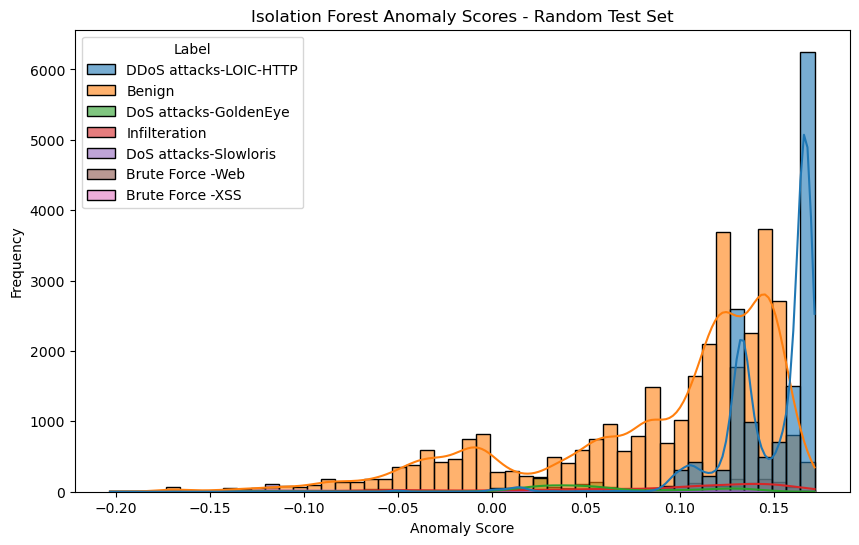

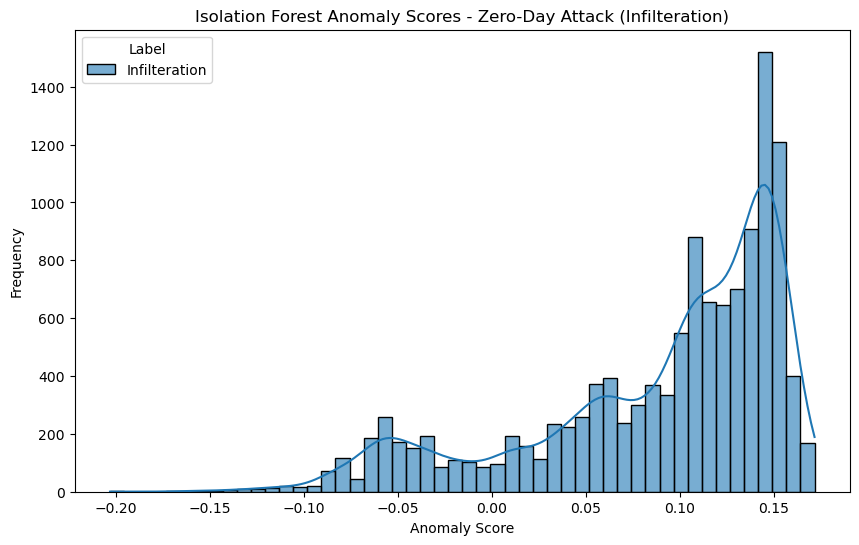

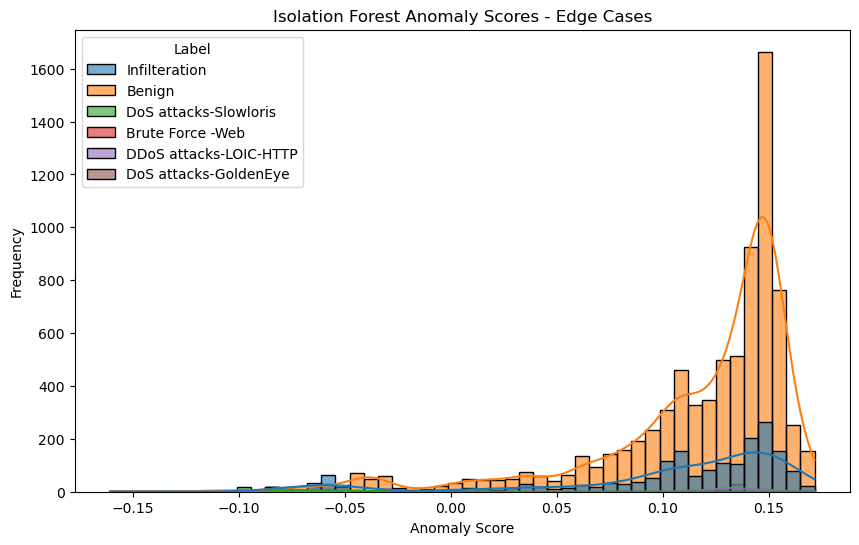

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define function to plot distributions
def plot_anomaly_scores(df, title):
    plt.figure(figsize=(10,6))
    sns.histplot(df, x="IF_Score", hue="Label", bins=50, kde=True, alpha=0.6)
    plt.title(title)
    plt.xlabel("Anomaly Score")
    plt.ylabel("Frequency")
    plt.show()

# Generate plots
plot_anomaly_scores(random_subset, "Isolation Forest Anomaly Scores - Random Test Set")
plot_anomaly_scores(test_unseen, "Isolation Forest Anomaly Scores - Zero-Day Attack (Infilteration)")
plot_anomaly_scores(edge_case_subset, "Isolation Forest Anomaly Scores - Edge Cases")

In [18]:
# Define threshold for anomaly detection (default is 0)
threshold = 0  # Adjust if needed

# Flag samples as anomalies if score < threshold
random_subset["IF_Anomaly"] = (random_subset["IF_Score"] < threshold).astype(int)
test_unseen["IF_Anomaly"] = (test_unseen["IF_Score"] < threshold).astype(int)
edge_case_subset["IF_Anomaly"] = (edge_case_subset["IF_Score"] < threshold).astype(int)

# Compute False Positive Rate (Benign misclassified as Anomaly)
fp_rate_random = random_subset[random_subset["Label"] == "Benign"]["IF_Anomaly"].mean()
fp_rate_unseen = test_unseen[test_unseen["Label"] == "Benign"]["IF_Anomaly"].mean()
fp_rate_edge = edge_case_subset[edge_case_subset["Label"] == "Benign"]["IF_Anomaly"].mean()

print(f"🔹 False Positive Rate - Random Set: {fp_rate_random:.4f}")
print(f"🔹 False Positive Rate - Zero-Day Set: {fp_rate_unseen:.4f}")
print(f"🔹 False Positive Rate - Edge Cases: {fp_rate_edge:.4f}")

🔹 False Positive Rate - Random Set: 0.1569
🔹 False Positive Rate - Zero-Day Set: nan
🔹 False Positive Rate - Edge Cases: 0.0446


C:\Users\S569652\AppData\Local\Temp\ipykernel_13156\684941119.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_unseen["IF_Anomaly"] = (test_unseen["IF_Score"] < threshold).astype(int)
C:\Users\S569652\AppData\Local\Temp\ipykernel_13156\684941119.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edge_case_subset["IF_Anomaly"] = (edge_case_subset["IF_Score"] < threshold).astype(int)


In [20]:
# Compute Anomaly Detection Rate (Percentage of anomalies flagged)
anomaly_detection_rate_unseen = test_unseen.groupby("Label")["IF_Anomaly"].mean()

print("\nAnomaly Detection Rate - Zero-Day Attack (Infilteration)")
print(anomaly_detection_rate_unseen)


Anomaly Detection Rate - Zero-Day Attack (Infilteration)
Label
Infilteration    0.134137
Name: IF_Anomaly, dtype: float64


In [21]:
# Retain only samples that IF flagged as anomalies
filtered_test_set = test_df[random_subset["IF_Score"] < threshold]  # Keep only anomalies

# Run XGBoost only on filtered data
y_pred_xgb_filtered = xgb_model.predict(filtered_test_set.drop(columns=["Label"]))

# Compare results
from sklearn.metrics import classification_report

print("\nXGBoost Performance AFTER Isolation Forest Filtering")
print(classification_report(filtered_test_set["Label"], y_pred_xgb_filtered))

C:\Users\S569652\AppData\Local\Temp\ipykernel_13156\1536636826.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_test_set = test_df[random_subset["IF_Score"] < threshold]  # Keep only anomalies


IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).